In [1]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# 1. Import Dataset

In [2]:
# from poc_data import PocDataset

# poc_raw_dataset = PocDataset(num_cases=2**10)
# data_loader = torch.utils.data.DataLoader(poc_raw_dataset,batch_size=128)
# batch, event, time_to_event, _latent_variable = next(iter(data_loader))

# print(batch.shape)
# print(event.shape)
# print(time_to_event.shape)
# print(_latent_variable.shape)

### Data Exploration

In [3]:
#Take a look at the longitudional data

# plt.plot(np.array(batch[0][:int(time_to_event[0]),1]), batch[0][:int(time_to_event[0]),2])
# plt.plot(np.array(batch[1][:int(time_to_event[1]),1]), batch[1][:int(time_to_event[1]),2])
# plt.plot(np.array(batch[2][:int(time_to_event[2]),1]), batch[2][:int(time_to_event[2]),2])
# plt.plot(np.array(batch[3][:int(time_to_event[3]),1]), batch[3][:int(time_to_event[3]),2])
# plt.plot(np.array(batch[4][:int(time_to_event[4]),1]), batch[4][:int(time_to_event[4]),2])

# print(event[:5])
# print(time_to_event[:5])
# print(_latent_variable[:5])

# 2. Hyperparameters

# 3. Defining The Model

# 4. Training the model

tensor([[ 0.0000, 15.4116,  0.1554],
        [ 0.0000, 15.9532, -0.1292],
        [ 0.0000, 16.4949, -0.3768],
        [ 0.0000, 17.0365, -0.5166],
        [ 0.0000, 17.5782, -0.5084],
        [ 0.0000, 18.1198, -0.3547],
        [ 0.0000, 18.6615, -0.0995],
        [ 0.0000, 19.2031,  0.1843],
        [ 0.0000, 19.7448,  0.4152],
        [ 0.0000, 20.2865,  0.5274]])


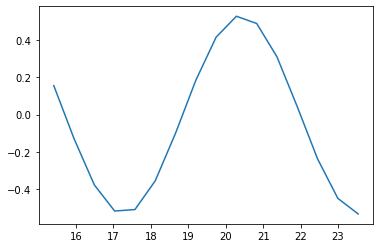

In [4]:
from poc_data import PocDataset

test_poc_raw_dataset = PocDataset(num_cases=1)
test_data_loader = torch.utils.data.DataLoader(test_poc_raw_dataset,batch_size=1)
test_batch, test_event, test_time_to_event, _latent_variable = next(iter(test_data_loader))

plt.plot(np.array(test_batch[0][:int(test_time_to_event[0]),1]), test_batch[0][:int(test_time_to_event[0]),2])
print(test_batch[0,:10])

In [5]:
from torch.nn import MSELoss
from tqdm import trange, tqdm

from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
from dynamicDeepHit import EncoderRNN, AttnDecoderRNN

#poc_raw_dataset = PocDataset(num_cases=2**5)
data_loader = torch.utils.data.DataLoader(test_poc_raw_dataset,batch_size=1)

NUM_EPOCHS = 5000
LEARNING_RATE = 0.0001
input_size = 3
output_size = input_size
hidden_size = 256
MAX_LENGTH = 30

# initialize model
encoder = EncoderRNN(input_size, hidden_size)
decoder = AttnDecoderRNN(hidden_size, output_size, MAX_LENGTH)

# intialize optimizer
optimizer_encoder = Adam(encoder.parameters(), lr=LEARNING_RATE)
optimizer_decoder = Adam(decoder.parameters(), lr=LEARNING_RATE)
 
# initialize loss
mse_loss = MSELoss()
writer = SummaryWriter()

tensor([[ 0.0890,  0.0923, -0.0694],
        [ 0.0910,  0.0862, -0.0688],
        [ 0.0912,  0.0823, -0.0652],
        [ 0.0900,  0.0792, -0.0625],
        [ 0.0891,  0.0774, -0.0610],
        [ 0.0884,  0.0759, -0.0603],
        [ 0.0879,  0.0747, -0.0600],
        [ 0.0876,  0.0740, -0.0600],
        [ 0.0875,  0.0736, -0.0601],
        [ 0.0876,  0.0733, -0.0601]], grad_fn=<SliceBackward>)


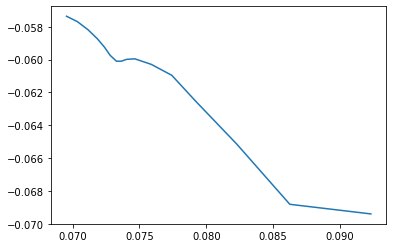

In [6]:
test_encoder_hidden_vector = torch.zeros(MAX_LENGTH, encoder.hidden_size)
test_encoder_output_vector = torch.zeros(MAX_LENGTH, encoder.input_size)
test_encoder_hidden = encoder.initHidden()

for ei in range(test_batch.size(1)):
        test_encoder_input = test_batch[0][ei].view(1,1,-1)
        test_encoder_output, test_encoder_hidden = encoder(test_encoder_input, test_encoder_hidden)
        test_encoder_output_vector[ei] = test_encoder_output

plt.plot(np.array(test_encoder_output_vector.detach()[:int(test_time_to_event[0]),1]), test_encoder_output_vector.detach()[:int(test_time_to_event[0]),2])
print(test_encoder_output_vector[:10])

In [7]:
# start training
for epoch in trange(NUM_EPOCHS):

  epoch_loss = 0

  for i, data in enumerate(data_loader):

    batch, event, time_to_event, _latent_variable = data

    optimizer_encoder.zero_grad()
    optimizer_decoder.zero_grad()

    encoder_hidden_vector = torch.zeros(MAX_LENGTH, encoder.hidden_size)
    encoder_output_vector = torch.zeros(MAX_LENGTH, encoder.input_size)
    encoder_hidden = encoder.initHidden()

    for ei in range(batch.size(1)):
        encoder_input = batch[0][ei].view(1,1,-1)
        encoder_output, encoder_hidden = encoder(encoder_input, encoder_hidden)
        #encoder_hidden_vector[ei] = self.encoder_hidden[0,0]
        encoder_output_vector[ei] = encoder_output

    loss3 = mse_loss(encoder_output_vector[:-1], batch.detach().squeeze(0)[1:])

    epoch_loss += loss3

  epoch_loss.backward()
  optimizer_encoder.step()
  
  writer.add_scalar('Loss/Train', epoch_loss.item(), epoch)
print("av_epoch_train_loss=", epoch_loss.item()/len(data_loader))

100%|██████████| 5000/5000 [03:11<00:00, 26.17it/s]

av_epoch_train_loss= 0.00018691217701416463


tensor([[ 0.0000, 15.4116,  0.1554],
        [ 0.0000, 15.9532, -0.1292],
        [ 0.0000, 16.4949, -0.3768],
        [ 0.0000, 17.0365, -0.5166],
        [ 0.0000, 17.5782, -0.5084],
        [ 0.0000, 18.1198, -0.3547],
        [ 0.0000, 18.6615, -0.0995],
        [ 0.0000, 19.2031,  0.1843],
        [ 0.0000, 19.7448,  0.4152],
        [ 0.0000, 20.2865,  0.5274]])


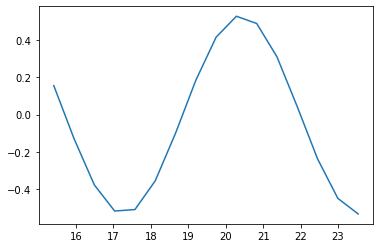

In [8]:
plt.plot(np.array(test_batch[0][:10,1]), test_batch[0][:10,2])
print(test_batch[0,:10])

tensor([[-1.6035e-03,  1.5951e+01, -1.5633e-01],
        [-2.9557e-03,  1.6496e+01, -3.6772e-01],
        [ 4.3692e-03,  1.7038e+01, -5.2008e-01],
        [ 3.0932e-03,  1.7577e+01, -5.0320e-01],
        [ 1.1960e-03,  1.8121e+01, -3.5973e-01],
        [-5.8743e-03,  1.8653e+01, -9.8220e-02],
        [-1.1574e-03,  1.9213e+01,  1.8693e-01],
        [ 2.8693e-04,  1.9759e+01,  4.3245e-01],
        [ 2.1316e-03,  2.0264e+01,  5.1522e-01],
        [ 1.1189e-03,  2.0825e+01,  4.5461e-01]])


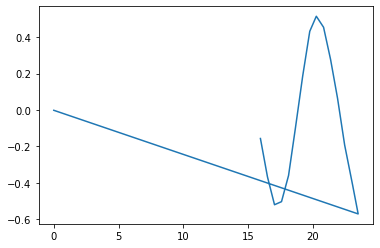

In [9]:
test_encoder_hidden_vector = torch.zeros(MAX_LENGTH, encoder.hidden_size)
test_encoder_output_vector = torch.zeros(MAX_LENGTH, encoder.input_size)
test_encoder_hidden = encoder.initHidden()

for ei in range(batch.size(1)):
        test_encoder_input = test_batch[0][ei].view(1,1,-1)
        test_encoder_output, test_encoder_hidden = encoder(test_encoder_input, test_encoder_hidden)
        test_encoder_output_vector[ei] = test_encoder_output

test_encoder_output_vector = test_encoder_output_vector.unsqueeze(0).detach()
plt.plot(np.array(test_encoder_output_vector[0][:10,1]), test_encoder_output_vector[0][:10,2])
print(test_encoder_output_vector[0,:10])